## PW on graphcut optimization (binary case)
This session is divided into 3 parts: 


* a part on Bayesian classification (see PW1 and PW2)
* a part on object/background segmentation of a colour image with a CRF (conditional random filed)
* a part on the iterative segmentation of a textured image

We will use the PyMaxflow library for the calculation of the graphcut.

In [1]:
!pip install PyMaxFlow

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import platform
import tempfile
import os
from scipy import ndimage as ndi
try:
    import maxflow # if not installed, install Maxflow
except:
    !pip install PyMaxflow # For Google Collab
    import maxflow


from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]], title=titre)
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

def display_segmentation_borders(image, bin):
    imagergb = np.copy(image)
    from skimage.morphology import binary_dilation, disk
    contour = binary_dilation(bin,disk(15))^bin
    imagergb[contour==1,0] = 255
    imagergb[contour==1,1] = 0
    imagergb[contour==1,2] = 0
    return imagergb

Loading BokehJS ...

## Binary classification of a noisy image

You have a binary image *IoriginaleBW.png* (binary image of the two classes) and its observed version with a certain distribution of grey levels for each class *Iobservee.png*. The objective is to perform a two-class classification of this observed image (see PW1 and PW2). 

### Analysis of the distributions of the 2 classes of the image}


Q1: What are the distributions of the two classes of the image ($P(Y_s|X_s=0)$ (black class) and $P(Y_s|X_s=0)$ (white class))? 

Q2: Give the means and variances of the two classes.

*The distributions and the means and variances found in the previous sessions will be used without justification*.

**Your answer &#x270D;**

A1: On considère que les distributions de ces deux classes sont gaussiennes de même variance

A2: On prend $\sigma = 26$ et $\mu_0 = 96$ et $\mu_1 = 160$

## 1.1: Graphcut optimization 

Q3: How many nodes does the graph have that is constructed for the search for the minimum capacity cut with only two neighbouring pixels? What do they correspond to? What do the data attachment terms in this graph correspond to and what values do they have for two observed pixels of values $y_s$ and $y_t$? What does the regularisation term correspond to?

**Your answer &#x270D;**

A3: Il y a 4 noeuds, les deux pixels, le puit et la source. Le terme d'attache aux données sera le poids de l'arête entre chaque pixel et la source avec une valeur de 0, et respectivement avec le puit avec une valeur de 1. Le terme de régularisation correspond au poids $\beta$ de l'arête entre les deux noeuds des pixels.

Q4: Complete the python code cell where it says "#TO BE COMPLETED EX1" with the data attachment and regularization terms as indicated. Run the minimum cut algorithm and view the result.

## 1.2 Searching for the optimal $\beta$.



Q5: By completing the program frame provided below, find the optimal $\beta$ value $\beta_{opt}$ using the "true image" $x$ corresponding to IoriginaleBW.png. You can plot the error values between $x$ and the estimated $\hat{x}$ to find $\beta_{opt}$. 



**Your answer &#x270D;**

A5: On trouve $\beta_{opt} = 1683 \pm 25 $

Q6: What are the advantages of this optimization approach compared to ICM? Compared to simulated annealing? In theory, do we obtain the same result with both methods (simulated annealing and graphcut)? Under what conditions? What is the advantage of simulated annealing in the general case?

**Your answer &#x270D;**

A6: Contrairement à l'ICM, cette méthode donne assurément le minimum d'énergie, et celà plus rapidement qu'avec le recuit simulé. Néanmoins le recuit simulé supporte des potentiels plus généraux et ne se limite pas à la quatre connexité.


Q7: How can you explain that the error rate with the true image can be lower with the simulated annealing result or the ICM than with the graph-cut optimisation? 
  

**Your answer &#x270D;**

A7: Le graph cut va bien optimiser de manière exacte le modèle tandis que le recuit simulé, s'il donne en théorie le même résultat, est moins précis. Le fait que l'on trouve des erreurs différentes vient du fait que le modèle choisie ne représente pas correctement l'image. Ainsi en l'optimisant rigoureusement on peut se retrouver avec une erreur plus importante que s'il on l'optimise de manière approché avec le recuit simulé par exemple.

Q8: What are the advantages and disadvantages of the Ising model?

**Your answer &#x270D;**

A8: Le modèle d'Ising va avoir tendance à favoriser la compacité et donc à effacer les structures ponctuelles et linéaires. Par contre il conserve bien les contours.

In [5]:
# Loading images

im_obs=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png')*255 # Observed image, noisy
im_orig=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png') # Binary reference image, to assess the quality of the segmentation

affiche(im_obs,titre='Observed image')

C:\Users\blanc\AppData\Local\Temp/ipykernel_14024/703461350.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  im_obs=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png')*255 # Observed image, noisy
C:\Users\blanc\AppData\Local\Temp/ipykernel_14024/703461350.py:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  im_orig=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png') # Binary reference image, to assess the quality of the segmentation


In [11]:
#### to be completed
# TO BE COMPLETED EX1
beta = 1683 # beta value 
m0 = 96   # m0 and m1 values from the previous practical work
m1 = 160

## binary graph-cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation

# Add the nodes. 
# nodeids has the identifiers of the nodes in the grid.
# It creates a set of nodes for all the pixels of the image
nodeids = g.add_grid_nodes(im_obs.shape) 

# Add non-terminal edges with the same capacity.
# the edge has the value beta for all adjacent pixels in 4-connexity
g.add_grid_edges(nodeids, beta) 

# Add the terminal edges.
# the second argument correspond to the set of edge values to the source 
# the third argument correspond to the set of edge values to the sink
g.add_grid_tedges(nodeids, (im_obs-m0)**2, (im_obs-m1)**2) 

# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the labels of the nodes in the grid.
# output is 0 if the node is connected to the source, else output is 1 
sgm = g.get_grid_segments(nodeids) 
im_bin = np.int_(np.logical_not(sgm))

affiche(im_bin,titre = "Result for beta = " + str(beta))
#%%


Max Flow: 76536317.0


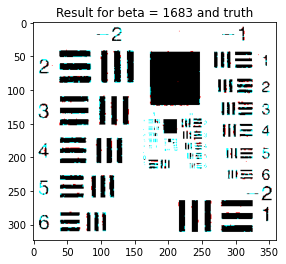

Number of misclassified pixels for beta =  1683 :  2412


In [12]:
# compute the error image between im_bin and im_orig (the ideal solution) using np.abs and np.sum 
error = np.sum(np.abs(im_bin-im_orig))

# visualize the differences between the original image and the solution
plt.figure()
plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
plt.title("Result for beta = " + str(beta) + " and truth")
plt.show()

print("Number of misclassified pixels for beta = ",beta,": ",int(error))

### Search for the best parameter $\beta$

C:\Users\blanc\AppData\Local\Temp/ipykernel_14024/1083562297.py:1: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  im_obs=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png')*255 # Observed image, noisy
C:\Users\blanc\AppData\Local\Temp/ipykernel_14024/1083562297.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  im_orig=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png') # Binary reference image, to assess the quality of the segmentation


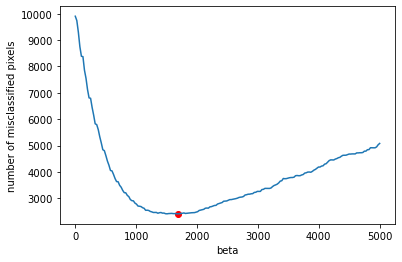

Best beta value:  1683.4170854271358


In [10]:
im_obs=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/Ibruitee.png')*255 # Observed image, noisy
im_orig=plt.imread('https://perso.telecom-paristech.fr/tupin/TPGRAPHCUT/OLD/IoriginaleBW.png') # Binary reference image, to assess the quality of the segmentation

list_beta = np.linspace(0,5000,200)
list_errors = []

# TO BE COMPLETED - choose a range of values and a step to study beta
for beta in list_beta:
    # TO BE COMPLETED
    m0 =  96
    m1 = 160

    ## Binary graph cut

    # Create the graph
    g = maxflow.Graph[float]() # graph instantiation

    # Add the nodes. nodeids has the identifiers of the nodes in the grid.
    nodeids = g.add_grid_nodes(im_obs.shape) 
    # Add non-terminal edges with the same capacity.
    g.add_grid_edges(nodeids, beta) 
    # Add the terminal edges.
    g.add_grid_tedges(nodeids, (im_obs-m0)**2, (im_obs-m1)**2) 
    
    # Find the maximum flow.
    flow = g.maxflow()

    # Get the segments of the nodes in the grid.
    sgm = g.get_grid_segments(nodeids) 
    # create the output image 
    im_bin =np.int_(np.logical_not(sgm))

    #print("beta = ",beta)
    #affiche(im_bin,titre = "Result for beta = " + str(beta))
    # compute the error
    error = np.sum(np.abs(im_bin-im_orig))
    #list_beta.append(beta)
    list_errors.append(error)

    
best_beta = list_beta[np.argmin(np.array(list_errors))]
least_error = np.array(list_errors).min()
plt.figure()
plt.plot(list_beta,list_errors)
plt.scatter(best_beta,least_error, c='r')
plt.xlabel("beta")
plt.ylabel("number of misclassified pixels")
plt.show()

best_beta = list_beta[np.argmin(np.array(list_errors))]

print('Best beta value: ', best_beta)

## 2. Classification of a colour image

The objective of this part is to carry out an extension of the method seen previously in the case of the treatment of a colour image *avions.png* in which one wants to separate the objects from the background.

We will first use the same framework (Ising model) as before but with a three-dimensional data attachment (assuming convariance matrices equal to the identity). Then we will introduce a CRF (conditional random field) by weighting the regularisation term of the Ising model by the modulus of the gradient between two pixels of the observed image.  



### 2.1 Binary classification

From the program structure below, carry out the different steps necessary for this classification:
1. Modelling of the background and object distributions (in 3 dimensions this time)
1. Definition of the data attachment term
1. Choice of a value for the regularisation parameter for the Ising model
1. Finding the minimal cut to obtain the object/background classification.

Q9: Comment on these steps and the results obtained.

**Your answer &#x270D;**

A9:
Implicitement on choisit de modéliser chaque des classes, et ce pour chaque canal, par une gaussienne dont on calcule la moyenne. On considère que toutes les variances sont égales. Par conséquent le terme d'attache aux données devient simplement une erreur quadratique.

Empiriquement on voit que $\beta= 4000$ est une bonne valeur pour le paramètre de régularisation. 

Enfin il reste une fois la classification effectuée pour chaque canal de chaque pixel à binariser l'image. On considère qu'un pixel est correctement dans la classe de l'avion lorsque tous les canaux de ce pixel on été correctement classées.

C:\Users\blanc\AppData\Local\Temp/ipykernel_14024/3300399800.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  im_obs=plt.imread('https://www.dropbox.com/s/ylm0ut8ipu5oonb/avions.png?dl=1')


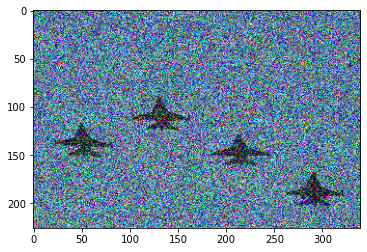

In [14]:
# Loading and displaying the image
im_obs=plt.imread('https://www.dropbox.com/s/ylm0ut8ipu5oonb/avions.png?dl=1')

plt.figure()
#plt.imshow(im_obs,vmin=0,vmax=255)
plt.rcParams['figure.figsize'] = [4, 4]
plt.imshow(im_obs)
plt.show()

# conversion of the image between 0 and 255
im_obs=255*im_obs

#### Determining the parameters of the classes


Plane class: we can use the values of the rectangle [180:200,280:300]. 

example np.mean(image[180:200,280:300,1]) returns the average of the selected area for channel 1

In [15]:
# mean of the plane class - 3D vector
planes = im_obs[180:200,280:300]
m_planes = np.array([planes[:,:,0].mean(),planes[:,:,1].mean(),planes[:,:,2].mean()])

# mean of the sky class
# you can use values in the following square [0:100,150:300]
sky = im_obs[0:100,150:300]
m_sky = np.array([sky[:,:,0].mean(),sky[:,:,1].mean(),sky[:,:,2].mean()])

print('For the sky, [R,G,B] = ', m_sky)
print("For the planes, [R,G,B] = ", m_planes)

# check that the obtained values are coherent

For the sky, [R,G,B] =  [ 93.961266 127.144264 156.2286  ]
For the planes, [R,G,B] =  [53.645  56.4725 70.2075]


Max Flow: 3262274543.822233


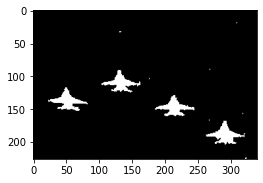

In [18]:
# choose a beta value 
beta = 10000
n,p,c = im_obs.shape
# TO BE COMPLETED
## Binary graph-cut 
# use the previous program to create the graph and compute the cut
# be careful of computing the terminal weights using the 3D values 
# you can compute 2 distance images with in each pixel the quadratic distance to the mean value 
# of each class 

## binary graph-cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation

# Add the nodes. 
# nodeids has the identifiers of the nodes in the grid.
# It creates a set of nodes for all the pixels of the image
nodeids = g.add_grid_nodes(im_obs.shape) 

# Add non-terminal edges with the same capacity.
# the edge has the value beta for all adjacent pixels in 4-connexity
g.add_grid_edges(nodeids,  beta) 

# Add the terminal edges.
# the second argument correspond to the set of edge values to the source 
# the third argument correspond to the set of edge values to the sink
g.add_grid_tedges(nodeids, np.sum(np.square(im_obs-m_planes),axis=2).reshape(n,p,1),np.sum(np.square(im_obs-m_sky),axis=2).reshape(n,p,1)) 

# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the labels of the nodes in the grid.
# output is 0 if the node is connected to the source, else output is 1 
sgm = g.get_grid_segments(nodeids) 

#im_bin = np.int_(np.logical_not(sgm))
#plt.imshow(im_bin)

im = np.where(sgm,[255,255,255],[0,0,0])
im_bin =np.int_(np.logical_not(np.all(sgm,axis=2)))

plt.imshow(im)
plt.show()
affiche(im_bin)

5000


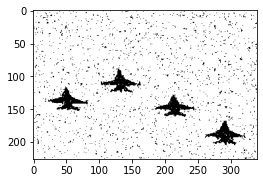

7500


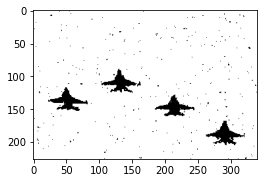

10000


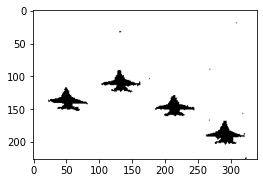

12500


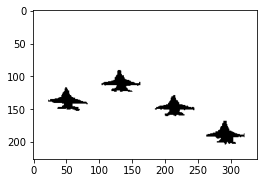

15000


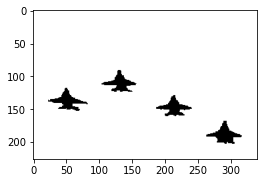

20000


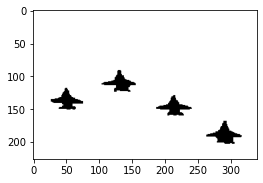

In [21]:
# choose a beta value 
beta_list = [5000,7500,10000,12500,15000,20000]
for beta in beta_list :
    print(beta)
    g = maxflow.Graph[float]() # Graph instantiation
    nodeids = g.add_grid_nodes(im_obs.shape) 
    g.add_grid_edges(nodeids,  beta) 
    g.add_grid_tedges(nodeids, np.sum(np.square(im_obs-m_planes),axis=2).reshape(n,p,1),np.sum(np.square(im_obs-m_sky),axis=2).reshape(n,p,1)) 
    flow = g.maxflow()
    sgm = g.get_grid_segments(nodeids) 
    im = np.where(sgm,[255,255,255],[0,0,0])
    im_bin =np.int_(np.logical_not(np.all(sgm,axis=2)))
    plt.imshow(im_bin,cmap='gray')
    plt.show()

### 2.2 Use of a CRF (Conditional Random Field) model

We will try here to adapt the model used previously to favour transitions where they are compatible with the gradient. To do this, we will replace the constant $\beta$ for the whole image by a "beta_field" which depends on the norm of the gradient.

Q10: Calculate and display the modulus of the gradient of the aircraft image after it has been grayscaled and convolved by a Gaussian kernel of standard deviation 1. Why use the "boundary='symm'" option when convolving through the Sobel filter? Try it without doing the Gaussian filtering. What is the point?

**Your answer &#x270D;**

A10: L'argument "symm" permet d'éviter de créer des bords sur l'image en effectuant une convolution circulaire. On évite ainsi de créer des valeurs aberrantes qui viendraient donner des valeurs trop faibles dans le champ de $\beta$. Le filter gaussien va légérement flouter l'image et celà a deux bénéfices : d'une part celà va permettre de limiter le bruit en uniformisant les valeurs et donc limiter les valeurs trop importantes du gradient, d'autre part il va aussi dans une moindre mesure agrandir les contours de façon à faciliter leur détection. 

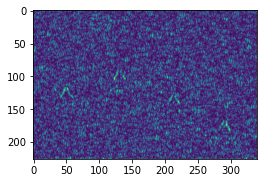

In [24]:
import scipy.signal as sig
import scipy.ndimage
from skimage import color

def gradient(image):
    """ Array -> tuple[Array*Array]"""
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float64)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float64)
    # to be completed
    # use mode = 'same' and boundary='symm' in scipy.signal.convolve2d
    derivative_x = sig.convolve2d(image, sobel_x, mode="same", boundary="symm")
    derivative_y = sig.convolve2d(image, sobel_y, mode="same", boundary="symm")
    return([derivative_x,derivative_y])

plane_nb = scipy.ndimage.gaussian_filter(color.rgb2gray(im_obs), 1)
plane_x, plane_y = gradient(plane_nb)
#plane_nb_without_gauss = color.rgb2gray(im_obs)
#plane_x, plane_y = gradient(plane_nb_without_gauss)
# calculation of the gradient modulus 
grad_av = np.sqrt( np.square(plane_x)+ np.square(plane_x) )
plt.figure()
plt.imshow(grad_av)
plt.show()


Complete the code for segmentation by CRF. We will choose $beta\_field=\beta_2\cdot\exp(-grad\_av/h)$ We can use $h=300$ and $\beta_2=20000$. Also replace the constant beta by the field "beta_field" during the "g.add_grid_edges" step.

Q11: Compare the results with and without the contour term.

**Your answer &#x270D;**

A11: Tout d'abord on choisit plutôt une valeur de $\beta$ de 4000 plutôt que de 20 000 car empiriquement on trouve de meilleur résultat.

Je ne sais pas trop pourquoi mais on obtient des résultats plutôt similaires avec une tendance à avoir de meilleures résultats sans utiliser de pondération par le gradient du paramètre de régularisation.

In [31]:
# calculation of beta_field 
# this field will set the value for the 4-neighbours 
h = 300
beta2 = 20000
#beta2 = 4000
beta_field = beta2 * np.exp(-grad_av/h)
print(beta_field.shape)
## Binary graph cut
# complete by taking your previous code and replacing 
# beta by beta_field in the line g.add_grid_edges
g = maxflow.Graph[float]() # Graph instantiation
nodeids = g.add_grid_nodes(im_obs.shape) 
g.add_grid_edges(nodeids, np.stack([beta_field,beta_field,beta_field],axis=2)) 
#g.add_grid_edges(nodeids, beta_field) 
g.add_grid_tedges(nodeids, np.sum(np.square(im_obs-m_planes),axis=2).reshape(n,p,1), np.sum(np.square(im_obs-m_sky),axis=2).reshape(n,p,1))
flow = g.maxflow()
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) # Returns 1 if the pixel is on the drain side after calculating the min cut, 0 if it is on the source side
#im_bin = np.int_(np.logical_not(sgm))
im_bin_w_gradient =np.int_(np.logical_not(np.all(sgm,axis=2)))

affiche(im_bin_w_gradient, titre="Result for the CRF model")

(226, 340)


Nombre pixel différent 289  soit  0.37610619469026546 %


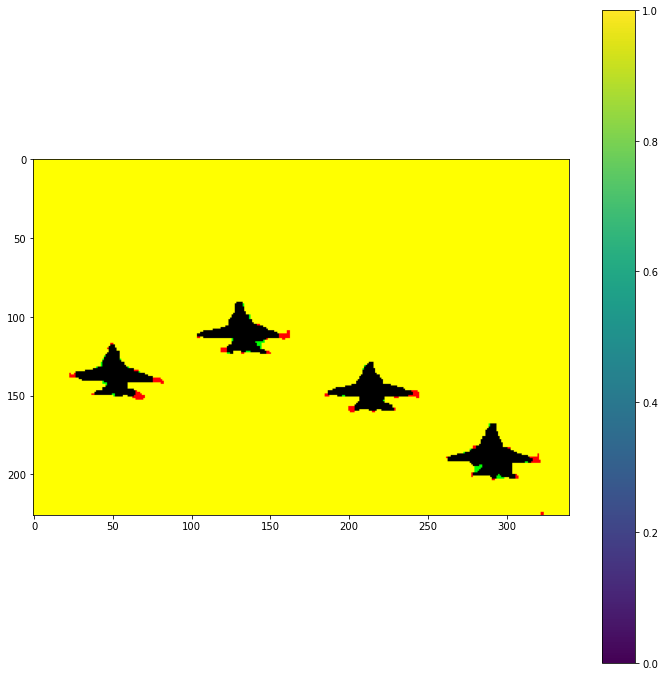

In [37]:
plt.figure(figsize=(12,12))
#plt.imshow(im_bin)
plt.imshow(np.dstack([im_bin,im_bin_w_gradient,np.zeros(im_bin.shape)]))
plt.colorbar()
erreur = np.sum(np.abs(im_bin - im_bin_w_gradient))
print("Nombre pixel différent",erreur," soit ", erreur/(im_bin.shape[0]*im_bin.shape[1]) *100, "%")

## 3. Iterative Segmentation with Gaussian Mixture

Q12: Display the "zebra" image below. Is it possible to segment the zebra with the method used to segment the planes?



**Your answer &#x270D;**

A12: On ne peut pas directement utiliser la méthode précédente pour segmenter l'image car la couleur du zèbre n'est pas globalement uniforme.

uint8


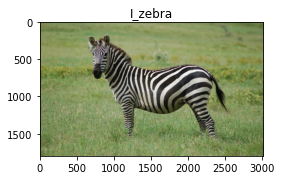

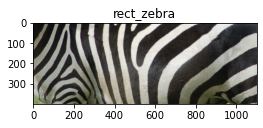

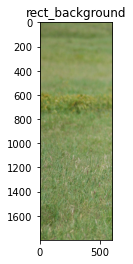

In [58]:
### Loading a new image
import imageio
I_zebra = imageio.imread('https://upload.wikimedia.org/wikipedia/commons/6/60/Equus_quagga.jpg')
I_zebra = I_zebra[200:,:,:]
rect_zebra = I_zebra[700:1100,1000:2100]
rect_background = I_zebra[:,0:600]
print(I_zebra.dtype)

plt.figure()
plt.imshow(I_zebra)
plt.title('I_zebra')
plt.show()

plt.figure()
plt.imshow(rect_zebra)
plt.title('rect_zebra')
plt.show()

plt.figure()
plt.imshow(rect_background)
plt.title('rect_background')
plt.show()

Q13: Calculate the covariance matrix for the rect_zebra and the rect_background. Display the values and comment on the result. What do the diagonal values correspond to?

**Your answer &#x270D;**

A13:
Les valeurs diagonales correspondent à la variance de la section de l'image choisie par composantes. On constate d'abord que les valeurs diagonales, et même les valeurs en général, de la matrice de covariance de la zone de l'image correspond à l'arrière-plan sont assez faibles. Cela témoigne du fait que la couleur de l'image est assez uniforme car les canaux sont corrélés. En revanche, on observe tout l'inverse avec des valeurs élevées pour l'image du zèbre. En effet il y a deux couleurs très différentes, les variances pour chaque canal sont donc importantes.

In [15]:
print(I_zebra.shape)
V_tulip = np.vstack([I_zebra[:,:,i].flatten() for i in range(3)])
print(V_tulip.shape)

M_cov = np.cov(np.vstack([I_zebra[:,:,i].flatten() for i in range(3)]))
print('Full zebra image')
print(M_cov)

M_cov = np.cov(np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]))
print('Rectangle zebra')
print(M_cov)

M_cov = np.cov(np.vstack([rect_background[:,:,i].flatten() for i in range(3)]))
print('Rectangle background')
print(M_cov)

(1800, 3008, 3)
(3, 5414400)
Full zebra image
[[1506.72829497 1532.31063252 1229.07656578]
 [1532.31063252 1691.94506099 1220.3208793 ]
 [1229.07656578 1220.3208793  1210.38796242]]
Rectangle zebra
[[5504.24135104 5535.45173735 5287.6066819 ]
 [5535.45173735 5589.55992729 5327.41135684]
 [5287.6066819  5327.41135684 5140.71619284]]
Rectangle background
[[314.66520718 225.26933203 255.5870428 ]
 [225.26933203 219.9126776  221.64616138]
 [255.5870428  221.64616138 309.65375015]]


Q14: Display the histogram for the R, G and B channels for the "rect_zebra" image. Comment on the result. 

**Your answer &#x270D;**

A14: Les stries sont probablement dues à la compression. On retrouve les résultats attendus par l'analyse des matrices de covariances.

Pour l'arrière-plan et pour chaque canal on retrouve une unique classe, voire deux classes très proches.

Pour le zèbre on retrouve plusieurs classes bien distinctes, deux ou trois par canal selon comment on interprète les histogrammes.

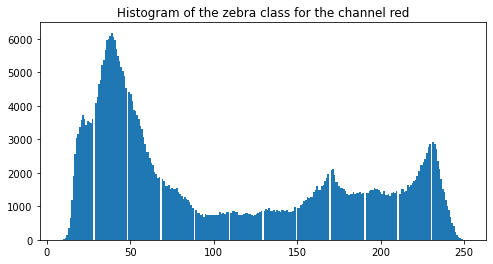

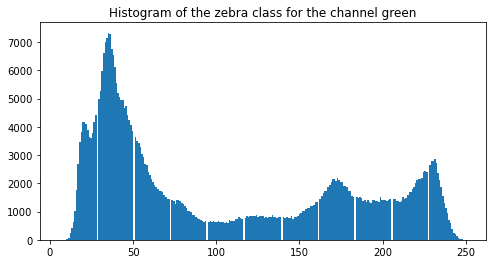

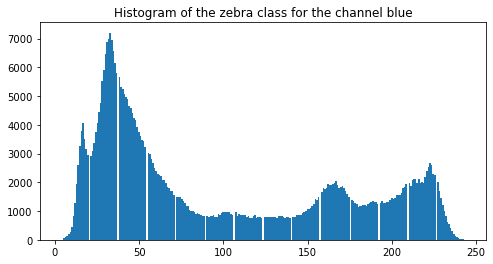

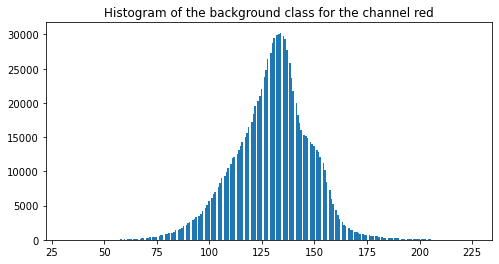

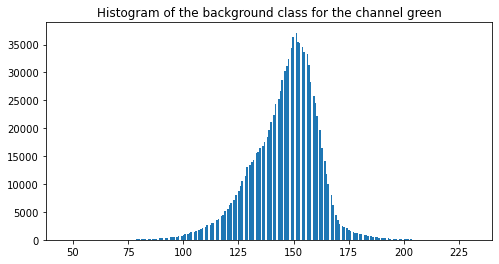

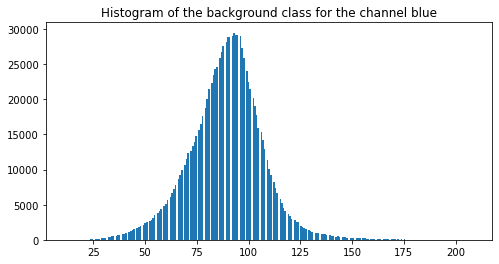

In [59]:
# allows you to change the display size of plt.show
plt.rcParams['figure.figsize'] = [8, 4]

nomchan = ["red","green", "blue"]
for chan in range(3):
    plt.figure()
    plt.hist(rect_zebra[:,:,chan].flatten(),255)
    plt.title("Histogram of the zebra class for the channel " + nomchan[chan])
    plt.show()
    
    
for chan in range(3):
    plt.figure()
    plt.hist(rect_background[:,:,chan].flatten(),255)
    plt.title("Histogram of the background class for the channel " + nomchan[chan])
    plt.show()

Q15: Propose an algorithmic method to identify the two classes of the image "rect_zebra". Use a sklearn implementation of this algorithm to identify the mean vectors ($m_R$,$m_G$,$m_B$) for two classes of the "rect_zebra" image and two classes of the "rect_background" image.

*The following line of code can be used to transform the image into a suitable form.*

X = np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]).transpose()

Comment on the average vectors obtained. They can be displayed as an image using the code provided.

**Your answer &#x270D;**

A15: On utilise l'algorithme des KMeans sur l'histogramme afin de déterminer la moyenne de chaque classe sur chaque canal à partir des centroides. On retrouve bien pour le zèbre du blanc(gris) et du noir, tandis qu'on a deux teintes de vert pour l'arrière-plan.

In [60]:
# computation of class parameters in a semi-automatic way
from sklearn.cluster import KMeans
import numpy as np

# use a number of classes =2 for the zebra part (complete n_clusters=?)
X = np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]).transpose()
kmeans_zebra = KMeans(n_clusters=2, random_state=0).fit(X)
mean_vectors_zebra = kmeans_zebra.cluster_centers_

# use a number of classes =2 for the background part
X = np.vstack([rect_background[:,:,i].flatten() for i in range(3)]).transpose()
kmeans_background = KMeans(n_clusters=2, random_state=0).fit(X)
mean_vectors_background = kmeans_background.cluster_centers_

191.07588010179737
190.5937245666645
179.99082812401207


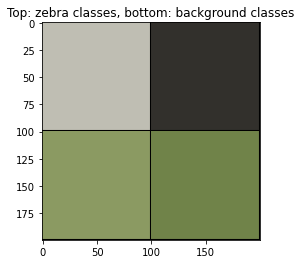

In [88]:
# display of the class centers found as an image
image_mean_vectors = np.zeros((200,200,3),np.uint8)
for i in range(3):
    image_mean_vectors[0:99,0:99,i] = mean_vectors_zebra[0,i]
    print(mean_vectors_zebra[0,i])
    image_mean_vectors[0:99,100:199,i] = mean_vectors_zebra[1,i]
    image_mean_vectors[100:199,0:99,i] = mean_vectors_background[0,i]
    image_mean_vectors[100:199,100:199,i] = mean_vectors_background[1,i]

plt.figure()
plt.imshow(image_mean_vectors,vmax = 255)
plt.title("Top: zebra classes, bottom: background classes")
plt.show()

Q16: Display separately two neg-log-likelihood images (the neg-log-likelihood was used as a data attachment in the previous example) for the two zebra classes.
Build a neg-log-likelihood image corresponding to the minimum of the two neg-log-likelihoods of the zebra classes. Similarly for the background class. 

Display them and comment.

**Your answer &#x270D;**

A16: On constate bien que pour le zèbre, chaque vraisemblance va permettre d'identifier une couleur de rayure. La première donne une erreur faible pour un type de rayure et l'autre vraisemblance de même pour l'autre type de rayure. C'est d'autant mieux qu'à chaque fois l'arrière-plan n'est quasiment jamais associé aux rayures. Par conséquent le minimum des deux vraisemblances permet d'identifier le zèbre.

On a le même raisonnement avec la vraissemblance liée à l'arrière-plan. Néanmoins on constate que malheureusement l'erreur sur les rayures noires reste assez faible.


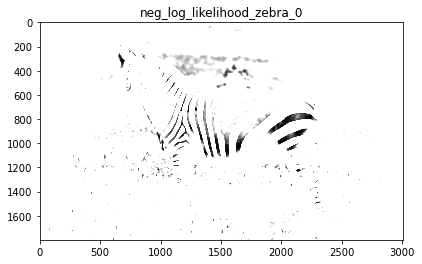

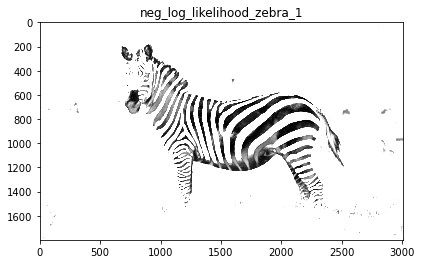

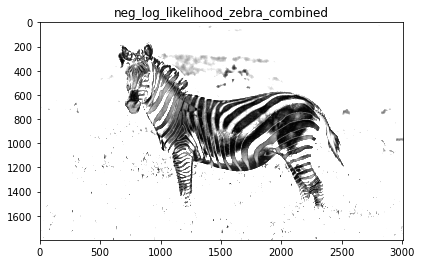

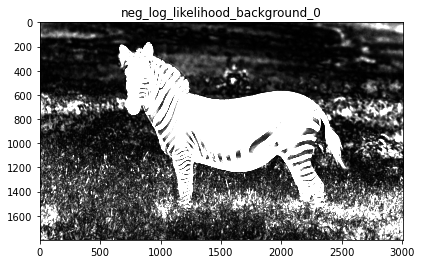

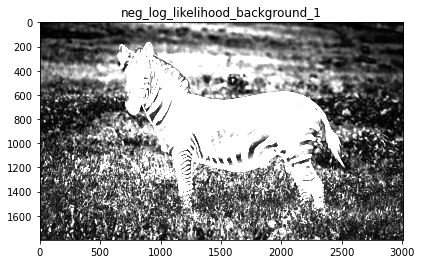

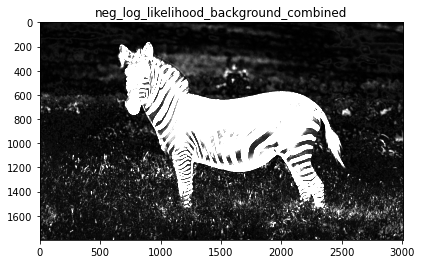

In [62]:
# calculation of the neg-log-likelihood of the zebra class
neg_log_likelihood_zebra_0 = sum((I_zebra[:,:,i]-mean_vectors_zebra[0,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_0,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_0")
plt.show()

neg_log_likelihood_zebra_1 = sum((I_zebra[:,:,i]-mean_vectors_zebra[1,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_1,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_1")
plt.show()

#neg_log_likelihood_zebra_combined = np.minimum(sum((I_zebra[:,:,i]-mean_vectors_zebra[0,i])**2 for i in range(3)),sum((I_zebra[:,:,i]-mean_vectors_zebra[1,i])**2 for i in range(3)))
neg_log_likelihood_zebra_combined = np.minimum(neg_log_likelihood_zebra_0,neg_log_likelihood_zebra_1)
plt.figure()
plt.imshow(neg_log_likelihood_zebra_combined,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_combined")
plt.show()
# TO BE COMPLETED
# calculate the neg-log-likelihood of the background 
# call the output neg_log_likelihood_background_combined

# calculation of the neg-log-likelihood of the background class
neg_log_likelihood_background_0 = sum((I_zebra[:,:,i]-mean_vectors_background[0,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_background_0,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_background_0")
plt.show()

neg_log_likelihood_background_1 = sum((I_zebra[:,:,i]-mean_vectors_background[1,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_background_1,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_background_1")
plt.show()

neg_log_likelihood_background_combined = np.minimum(neg_log_likelihood_background_0,neg_log_likelihood_background_1)
plt.figure()
plt.imshow(neg_log_likelihood_background_combined,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_background_combined")
plt.show()


Q17: From these combined data attachment images (one for the background and one for the zebra), set up a graph-cut segmentation of the image with the $\beta$ of your choice. Comment the result.

**Your answer &#x270D;**

A17: Cela fonctionne plutôt bien même si on constate que certaines zones ne sont pas dans la bonne classe. Je ne sais pas pourquoi la valeur de $\beta$ doit être si élevée pour obtenir de bon résultats. Je suppose que celà a à faire avec l'amplitude de la valeur des erreurs.

In [66]:
beta =  206000 # Optimal beta value to be determined
#beta_field = neg_log_likelihood_zebra_combined
## Binary graph cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(I_zebra.shape[0:2]) # Create a grid with a non-terminal node for each pixel in the image
# Add non-terminal edges with the same capacity.

#g.add_grid_edges(nodeids, beta_field) # Addition of a beta weight edge between each adjacent node according to the 4-connexity
g.add_grid_edges(nodeids, beta) # Addition of a beta weight edge between each adjacent node according to the 4-connexity

# Add the terminal edges.

# TO BE COMPLETED
g.add_grid_tedges(nodeids, neg_log_likelihood_zebra_combined, neg_log_likelihood_background_combined ) 


# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) 
im_bin = np.int_(np.logical_not(sgm))


Max Flow: 6917238291.698392


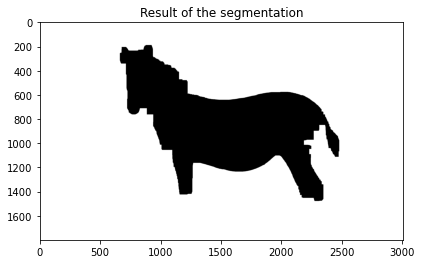

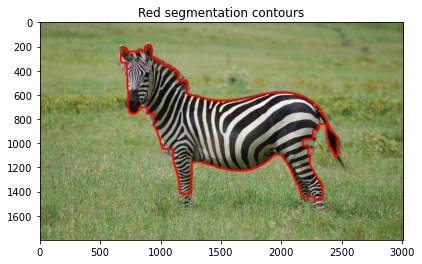

In [68]:
plt.figure()
plt.imshow(im_bin, cmap='gray')
plt.title("Result of the segmentation")
plt.show()

plt.figure()
plt.imshow(display_segmentation_borders(I_zebra, im_bin))
plt.title("Red segmentation contours")
plt.show()

Q18: From the obtained segmentation, determine the mean vectors for 5 classes for the background and 5 classes for the zebra. Use these lists of mean vectors to construct new neg-log-likelihood combination images. Comment on them.

**Your answer &#x270D;**

A18: On obtient des résultats similaires sur l'arrière-plan mais on constate que pour le zèbre on va avoir moins tendance à associer une erreur faible aux pixels des rayures.

In [69]:
# The computing of this cell can take several minutes.

X_1 = np.vstack([I_zebra[im_bin==0,i].flatten() for i in range(3)]).transpose()
kmeans_zebra2 = KMeans(n_clusters=5, random_state=0).fit(X_1)
mean_vectors_zebra2 = kmeans_zebra2.cluster_centers_

X_2 = np.vstack([I_zebra[im_bin==1,i].flatten() for i in range(3)]).transpose()
kmeans_background2 = KMeans(n_clusters=5, random_state=0).fit(X_2)
mean_vectors_background2 = kmeans_background2.cluster_centers_

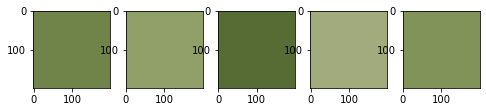

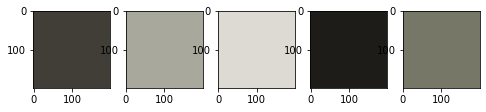

In [101]:
for k in range(5):
    im_class_k = np.ones((200,200,3),dtype=np.float64)* mean_vectors_background2[k] /255
    axk = plt.subplot(1,5,k+1)
    axk.imshow(im_class_k)
plt.show()
for k in range(5):
    im_class_k = np.ones((200,200,3),dtype=np.float64)* mean_vectors_zebra2[k] /255
    axk = plt.subplot(1,5,k+1)
    axk.imshow(im_class_k)
plt.show()

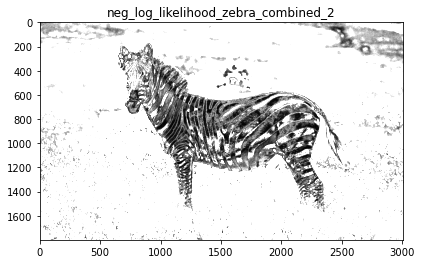

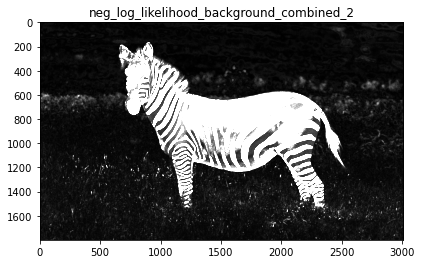

In [102]:
neg_log_likelihood_zebra_combined_2 = np.amin(np.dstack([(sum((I_zebra[:,:,i]-mean_vectors_zebra2[n_cl,i])**2 for i in range(3))) for n_cl in range(len(mean_vectors_zebra2))]),2)

neg_log_likelihood_background_combined_2 = np.amin(np.dstack([(sum((I_zebra[:,:,i]-mean_vectors_background2[n_cl,i])**2 for i in range(3))) for n_cl in range(len(mean_vectors_background2))]),2)

plt.figure()
plt.imshow(neg_log_likelihood_zebra_combined_2 ,cmap='gray', vmax = 1000)
plt.title("neg_log_likelihood_zebra_combined_2")
plt.show()

plt.figure()
plt.imshow(neg_log_likelihood_background_combined_2,cmap='gray', vmax = 3000)
plt.title("neg_log_likelihood_background_combined_2")
plt.show()


Q19: From these neg-log-likelihood images, segment the image by graph-cut using a new value of $\beta$ that gives you the best result. Comment on the result and the new value of $\beta$ that allowed you to obtain it. What about the new 5-class data attachment compared to the previous one?

**Your answer &#x270D;**

A19: On trouve un résultat qui à l'oeil nu à l'air parfait sauf pour une petite zone autour de l'oreille gauche, et ce avec une valeur de $\beta$ presque 20 fois moindre. La première segmentation a permis de rafiner la zone à considérer pour chaque classe. De ce fait on peut ensuite utiliser plus de classes pour les Kmeans. Celà permet de choisir le terme d'attache aux données qui est minimal parmi toutes les nouvelles sous-classes. Par conséquent on a globalement des termes d'attaches aux données d'amplitude plus faible, ce qui traduit un meilleur prior sur l'image et entraine aussi un $\beta$ plus faible.

Max Flow: 1448388537.2207074


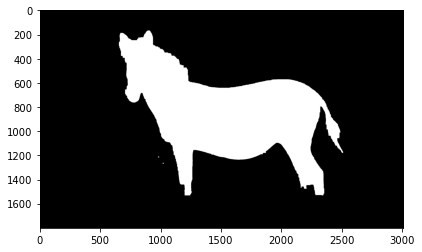

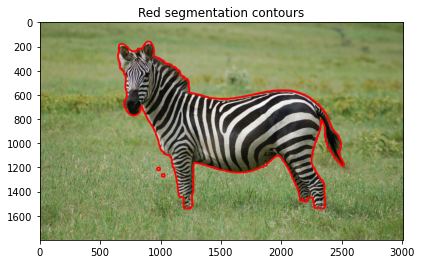

In [103]:
beta = 10000 # Optimal beta value to be determined

g = maxflow.Graph[float]() # Graph instantiation
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(I_zebra.shape[0:2]) 
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, beta)
# Add the terminal edges.
g.add_grid_tedges(nodeids,neg_log_likelihood_background_combined_2, neg_log_likelihood_zebra_combined_2) 

flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) # Returns 1 if the pixel is on the drain side after calculation of the min cut, 0 if it is on the source side
im_bin = np.int_(np.logical_not(sgm))

#affiche(im_bin, titre="Result for beta = " + str(beta))

plt.figure()
plt.imshow(im_bin,cmap='gray')
plt.show()

plt.figure()
plt.imshow(display_segmentation_borders(I_zebra, im_bin))
plt.title("Red segmentation contours")
plt.show()